# Moving average crossover Strategy
- strategy: `script/strategy.py -> mac()`
- generate signals
- backtest: `script/backtest.py -> bt()`
- evaluation: **Sharpe ratio**,..., etc.

In [1]:
import pandas as pd
import numpy as np
data_folder = "./data/"
crypto_df = pd.read_csv(data_folder + 'train.csv')
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

## Trading rule details

- Use **BTC** for testing the strategy.
- create two separate Simple Moving Averages (SMA) of a time series with differing lookback periods,
    let’s say, 40 days and 100 days. 
- long moving tends toward short moving.
- If the short moving average exceeds the long moving average then you go long.
- if the long moving average exceeds the short moving average then you exit.
- Only long/sell once if consecutive signal occurs.
- ignore the transaction fee for now.

In [5]:
btc = crypto_df[crypto_df["Asset_ID"]== 1 ]
btc

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2,1514764860,1,229.0,13835.194000,14013.800000,13666.11,13850.176000,31.550062,13827.062093,-0.014643
10,1514764920,1,235.0,13835.036000,14052.300000,13680.00,13828.102000,31.046432,13840.362591,-0.015037
18,1514764980,1,528.0,13823.900000,14000.400000,13601.00,13801.314000,55.061820,13806.068014,-0.010309
26,1514765040,1,435.0,13802.512000,13999.000000,13576.28,13768.040000,38.780529,13783.598101,-0.008999
34,1514765100,1,742.0,13766.000000,13955.900000,13554.44,13724.914000,108.501637,13735.586842,-0.008079
...,...,...,...,...,...,...,...,...,...,...
24236739,1632182160,1,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499,NaN
24236753,1632182220,1,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084,NaN
24236767,1632182280,1,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693,NaN
24236781,1632182340,1,4047.0,42839.012802,43042.160000,42818.10,43017.277143,138.335477,42935.761938,NaN


## Generate signals for daily BTC

- use daily BTC close price as the asset price to trade with.
- signal code '1' short moving average exceeds the long moving average, signal code '0' otherwise.
- visualize the signals that '^' for "buying" and 'v' for "selling".

/Users/dingxian/Documents/GitHub/Crypto_Forecasting_kaggle/script/morestats.py:29: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t = date_str.astype('int64') // 10**9 ##unix time with nanoseconds //10**9


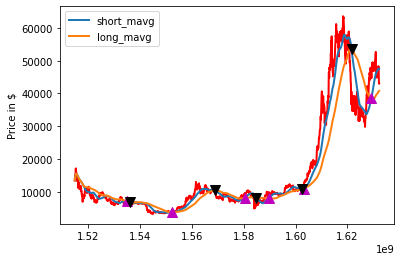

,signal,short_mavg,long_mavg,positions
1514851200,0.0,13432.9180,13432.9180,NaN
1514937600,0.0,14089.5150,14089.5150,0.0
1515024000,0.0,14427.0080,14427.0080,0.0
1515110400,0.0,14608.9460,14608.9460,0.0
1515196800,0.0,15077.1328,15077.1328,0.0


In [7]:
from script.strategy import mac
from script.morestats import ohlcv_with_frequency
btc_daily = ohlcv_with_frequency(df = btc,frequency='1D')
signals = mac(asset_df=btc_daily,
                price_col='Close', short_window=40,long_window=100, plot_signal=True)
signals.head()

## Backtesting on daily BTC
- We buy or sell the fixed share once on the first signal among consecutive same signals.
- The share to buy or sell every time is fixed as 100 unit(level doesn't matter when fixed).
- Initial capital to play is 100000 USD.
- Visualize the account balance change.

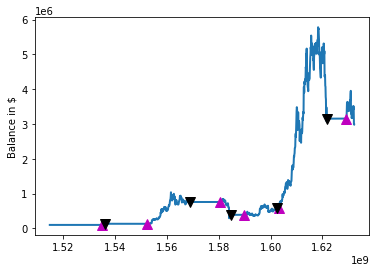

,Shares,holdings,cash,balance,returns
1514851200,0.0,0.0,100000.0,100000.0,NaN
1514937600,0.0,0.0,100000.0,100000.0,0.0
1515024000,0.0,0.0,100000.0,100000.0,0.0
1515110400,0.0,0.0,100000.0,100000.0,0.0
1515196800,0.0,0.0,100000.0,100000.0,0.0


In [8]:
from script.backtest import bt
portfolio = bt(asset_df=btc_daily, signals=signals, strategy='mac',
                initial_capital = float(100000.0), price_col= 'Close', 
                shares_signal=100, plot_balance=True)
portfolio.head()

## Evaluate the strategy
- Sharpe ratio: the ratio between the returns and the additional risk that is incurred is quite OK. Usually, a ratio greater than 1 is acceptable by investors, 2 is very good and 3 is excellent. $$S_{a}=\frac{E\left[R_{a}-R_{risk free}\right]}{\sigma_{a}}$$
- Maximum Drawdown: the largest single drop from peak to bottom in the value of a portfolio before a new peak is achieved.
- Compound Annual Growth Rate (CAGR): $$(EV / BV)^{1 / n}-1$$
- distribution of returns
- trade-level metrics

In [10]:
returns = portfolio['returns']
# annualized Sharpe ratio, BTC market opens everyday
daily_sharpe =(returns.mean() - 0 )/ returns.std()
sharpe_ratio = np.sqrt(365) * daily_sharpe
sharpe_ratio

1.512202147383543